<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-04-10 04:25:58--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-04-10 04:25:58 (12.5 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

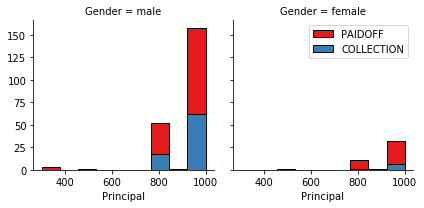

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

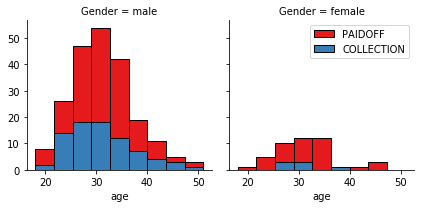

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

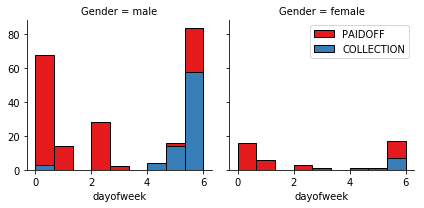

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek    # Mon=0 Sun=6
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0) # weekday Mon-Thur | weekend Fri-Sun
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Train Test Split
Split data into train and test sets with ratio of 2:1. Print the shapes of the splitted sets to make sure the process is successful.

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (231, 8) (231,)
Test set: (115, 8) (115,)


# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

In [21]:
# confusion_matrix plot function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

max_k = 11
mean_acc = np.zeros(max_k-1)
std_acc = np.zeros(max_k-1)

for k in range(1,max_k):
    
    # Train model and predict
    neigh = KNeighborsClassifier(k)
    neigh.fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    
    # Calculate accuracy and standard deviation of accuracy
    mean_acc[k-1] = accuracy_score(y_test, yhat)
    std_acc[k-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
print('Accuracy', mean_acc)    

Accuracy [ 0.73913043  0.62608696  0.73913043  0.69565217  0.75652174  0.73043478
  0.77391304  0.69565217  0.76521739  0.74782609]


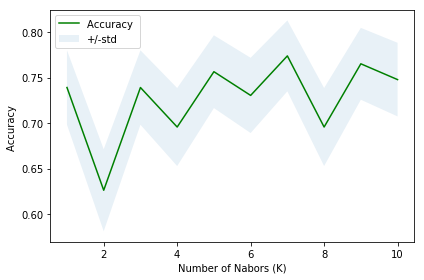

In [23]:
# Plot the model accuracy for different k values
plt.plot(range(1,max_k),mean_acc,'g')
plt.fill_between(range(1,max_k), mean_acc-1*std_acc, mean_acc+1*std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/-std'), loc='upper left')
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

The best k of the KNN classifier within range from 1 to 10 for this dataset is 7 with the accuracy of 77.4%.

             precision    recall  f1-score   support

 COLLECTION       0.33      0.30      0.32        20
    PAIDOFF       0.86      0.87      0.86        95

avg / total       0.76      0.77      0.77       115

Confusion matrix, without normalization
[[83 12]
 [14  6]]


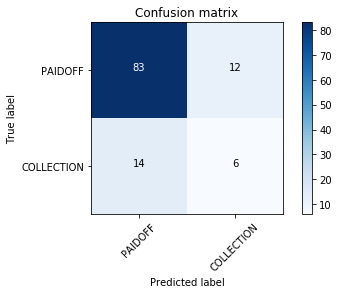

In [24]:
neigh = KNeighborsClassifier(7).fit(X_train, y_train)
yhat_neigh = neigh.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_neigh, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_neigh))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'], normalize=False,  title='Confusion matrix')

# Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

max_d = 7
mean_acc = np.zeros(max_d-1)

for d in range(1, max_d):
    tree = DecisionTreeClassifier(max_depth=d)
    tree.fit(X_train, y_train)
    yhat = tree.predict(X_test)
    mean_acc[d-1] = accuracy_score(y_test, yhat)
print('Accuracy', mean_acc)

Accuracy [ 0.83  0.83  0.83  0.82  0.7   0.7 ]


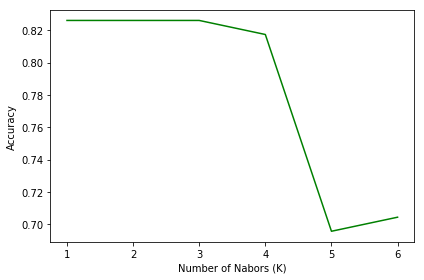

In [27]:
# Plot the model accuracy for different depth
plt.plot(range(1,max_d),mean_acc,'g')
plt.ylabel('Accuracy')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

I generate the plot of the decision trees with max depth of 2, 3, and 4. All the classes in the leaf nodes of max_depth=2 and 3 is 'PAIDOFF'. So I select max_depth of 4 even it doesn't have the highest accuracy but it does have a node of 'COLLECTION' class. 

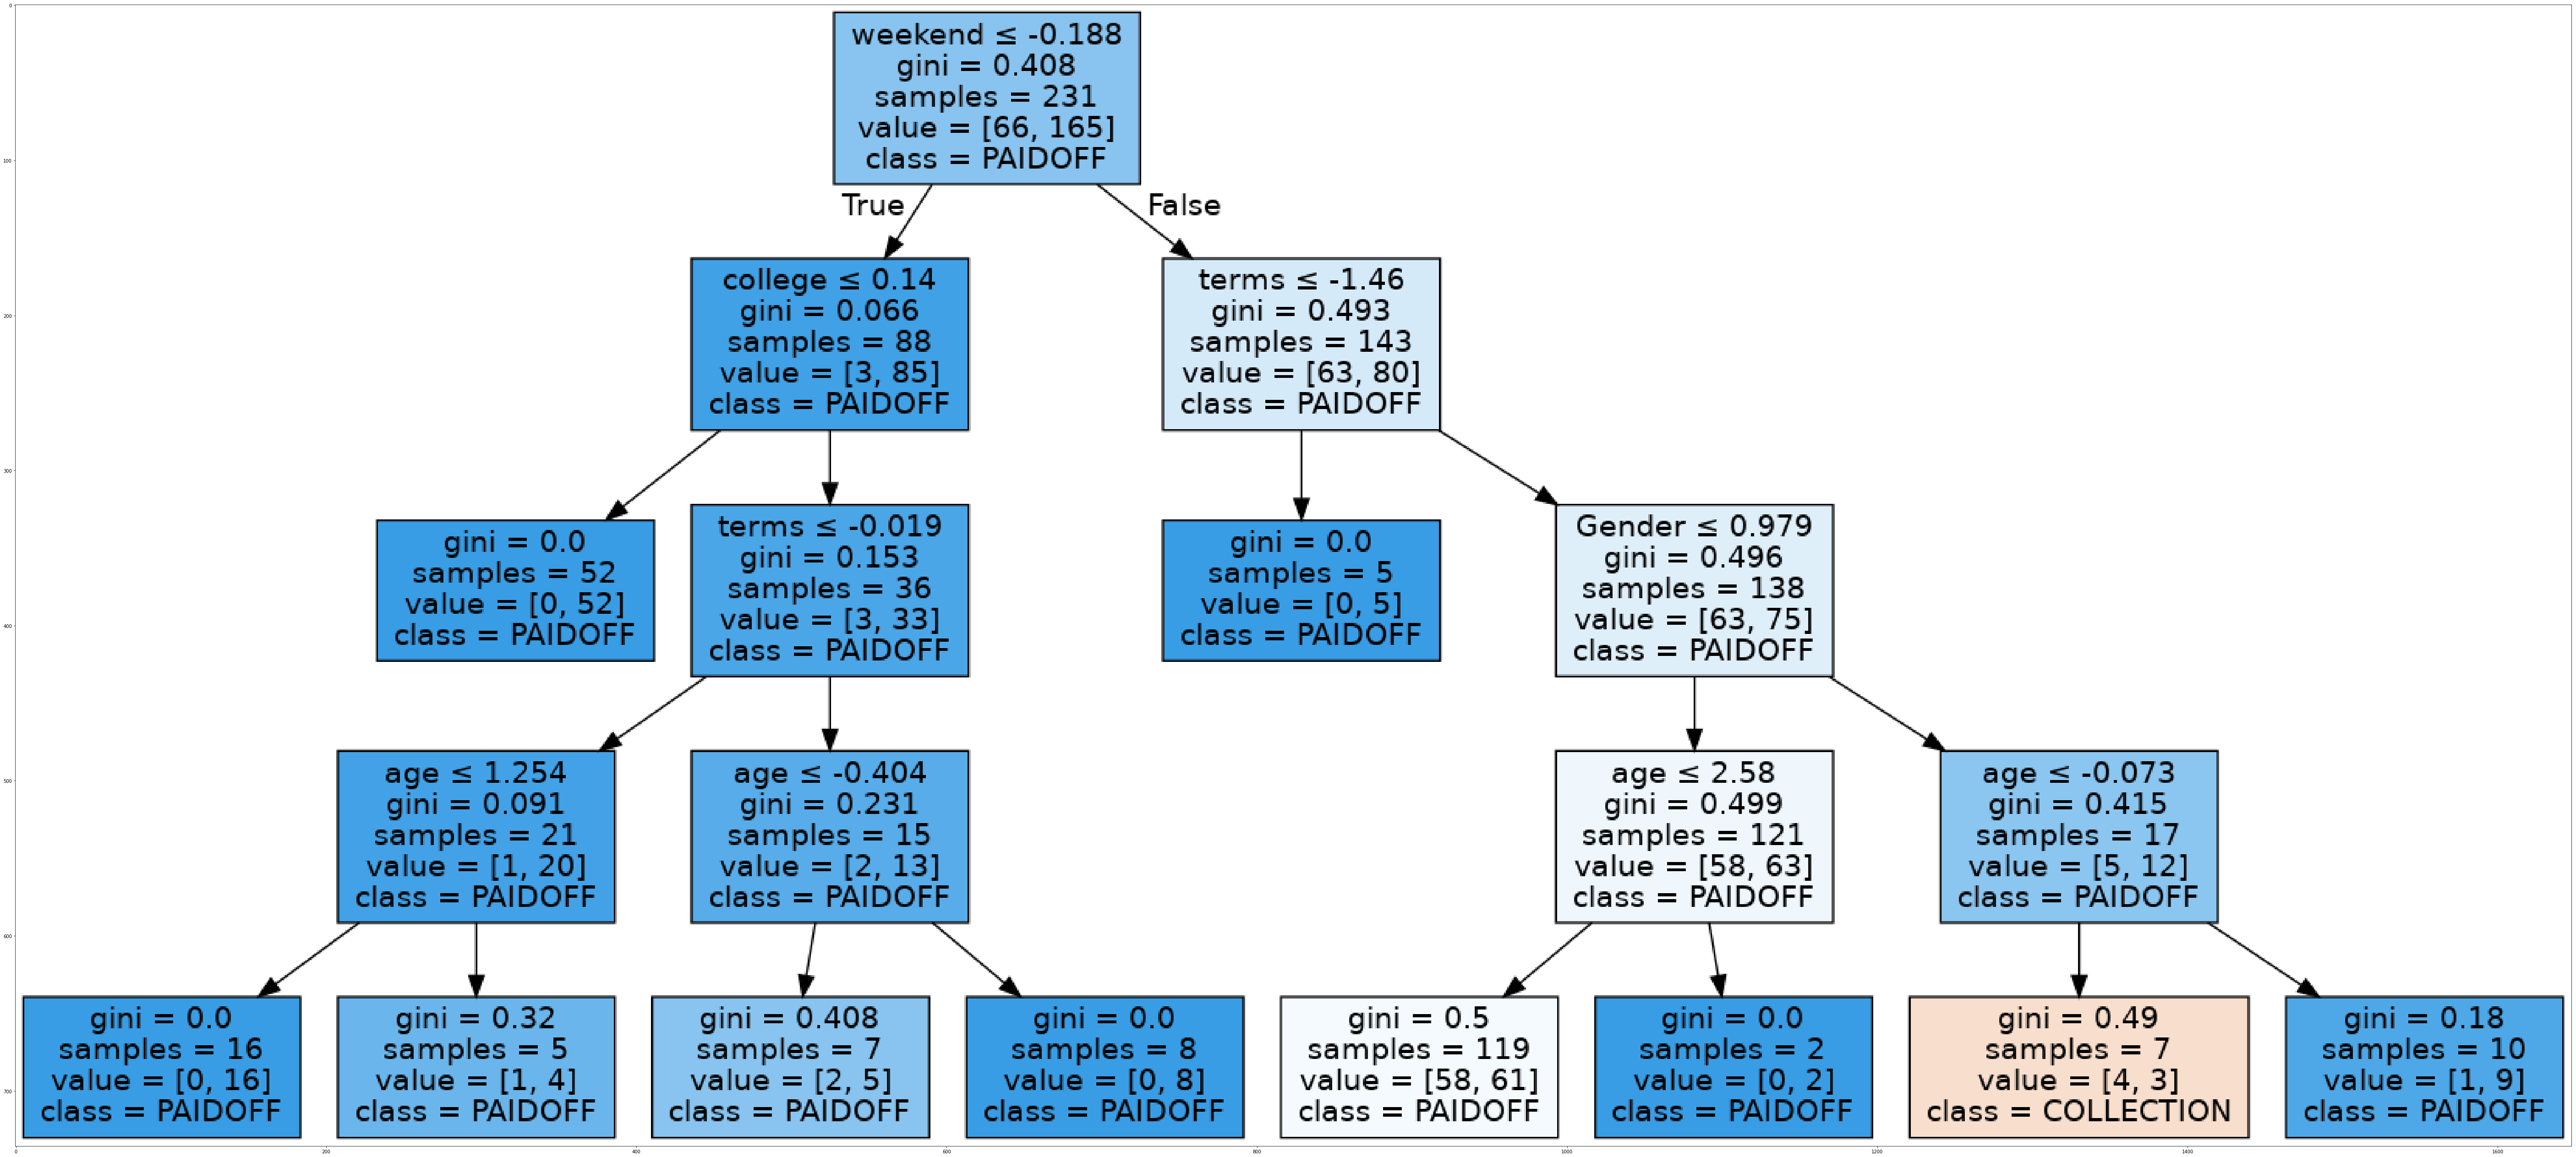

In [31]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

tree2 = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)
yhat_tree = tree2.predict(X_test)

dot_data = StringIO()
filename = "drugtreecapstone.png"
featureNames = Feature.columns
targetNames = df['loan_status'].unique().tolist()
out=tree.export_graphviz(tree2,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

             precision    recall  f1-score   support

 COLLECTION       0.40      0.10      0.16        20
    PAIDOFF       0.84      0.97      0.90        95

avg / total       0.76      0.82      0.77       115

Confusion matrix, without normalization
[[92  3]
 [18  2]]


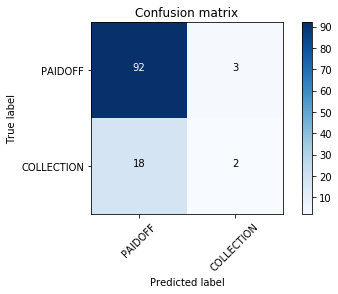

In [32]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_tree, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_tree))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'], normalize=False,  title='Confusion matrix')

# Support Vector Machine

In [33]:
from sklearn import svm
from sklearn.metrics import classification_report

# Build SVM models with different kernel methods
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for k in kernels:
    clf = svm.SVC(kernel=k)
    clf.fit(X_train, y_train)
    yhat_svm = clf.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, yhat_svm, labels=['PAIDOFF','COLLECTION'])
    np.set_printoptions(precision=2)
    print(k, '\n', classification_report(y_test, yhat_svm))

linear 
              precision    recall  f1-score   support

 COLLECTION       0.00      0.00      0.00        20
    PAIDOFF       0.83      1.00      0.90        95

avg / total       0.68      0.83      0.75       115

poly 
              precision    recall  f1-score   support

 COLLECTION       0.40      0.10      0.16        20
    PAIDOFF       0.84      0.97      0.90        95

avg / total       0.76      0.82      0.77       115

rbf 
              precision    recall  f1-score   support

 COLLECTION       0.25      0.20      0.22        20
    PAIDOFF       0.84      0.87      0.86        95

avg / total       0.74      0.76      0.75       115

sigmoid 
              precision    recall  f1-score   support

 COLLECTION       0.40      0.20      0.27        20
    PAIDOFF       0.85      0.94      0.89        95

avg / total       0.77      0.81      0.78       115



/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


From the report above we can see that poly method works best among all the kenel function options.

sigmoid 
              precision    recall  f1-score   support

 COLLECTION       0.40      0.20      0.27        20
    PAIDOFF       0.85      0.94      0.89        95

avg / total       0.77      0.81      0.78       115

Confusion matrix, without normalization
[[89  6]
 [16  4]]


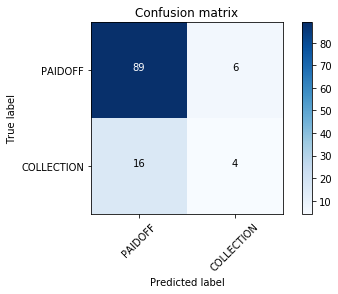

In [34]:
clf = svm.SVC(kernel=k)
clf.fit(X_train, y_train)
yhat_svm = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, yhat_svm, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)
print(k, '\n', classification_report(y_test, yhat_svm))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'], normalize=False,  title='Confusion matrix')

# Logistic Regression

sigmoid 
              precision    recall  f1-score   support

 COLLECTION       0.41      0.35      0.38        20
    PAIDOFF       0.87      0.89      0.88        95

avg / total       0.79      0.80      0.79       115

Confusion matrix, without normalization
[[85 10]
 [13  7]]


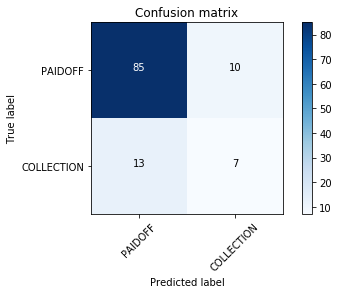

In [36]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train)
yhat_lr = lr.predict(X_test)

cnf_matrix = confusion_matrix(y_test, yhat_lr, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)
print(k, '\n', classification_report(y_test, yhat_lr))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'], normalize=False,  title='Confusion matrix')

# Model Evaluation using Test set

In [37]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [38]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-04-10 04:42:00--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-04-10 04:42:00 (532 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [48]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [49]:
# Test data preprocessing
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek    # Mon=0 Sun=6
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0) # weekday Mon-Thur | weekend Fri-Sun
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
testX = test_Feature
tesety = test_df['loan_status'].values
testX = preprocessing.StandardScaler().fit(testX).transform(testX)

In [50]:
yhat_neigh = neigh.predict(testX)
yhat_tree = tree2.predict(testX)
yhat_svm = clf.predict(testX)
yhat_lr = lr.predict(testX)
yhat_lr_prob = lr.predict_proba(testX)

In [52]:
print('Jaccord coefficient of KNN is', jaccard_similarity_score(tesety, yhat_neigh))
print('Jaccord coefficient of Decision Tree is', jaccard_similarity_score(tesety, yhat_tree))
print('Jaccord coefficient of SVM is', jaccard_similarity_score(tesety, yhat_svm))
print('Jaccord coefficient of Logistic Regression is', jaccard_similarity_score(tesety, yhat_lr))

Jaccord coefficient of KNN is 0.703703703704
Jaccord coefficient of Decision Tree is 0.777777777778
Jaccord coefficient of SVM is 0.703703703704
Jaccord coefficient of Logistic Regression is 0.777777777778


In [53]:
print('F1 score of KNN is', f1_score(tesety, yhat_neigh, average='weighted'))
print('F1 score of Decision Tree is', f1_score(tesety, yhat_tree, average='weighted'))
print('F1 score of SVM is', f1_score(tesety, yhat_svm, average='weighted'))
print('F1 score of Logistic Regression is', f1_score(tesety, yhat_lr, average='weighted'))

F1 score of KNN is 0.657912457912
F1 score of Decision Tree is 0.728395061728
F1 score of SVM is 0.657912457912
F1 score of Logistic Regression is 0.743434343434


In [54]:
print('Log loss of Logistic Regression is', log_loss(tesety, yhat_lr_prob))

Log loss of Logistic Regression is 0.589110453181


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.7037  | 0.6579   | NA      |
| Decision Tree      | 0.7778  | 0.7284   | NA      |
| SVM                | 0.7037  | 0.6579   | NA      |
| LogisticRegression | 0.7778  | 0.7434   | 0.5891  |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>